In [26]:
import numpy as np
import scipy as sp
from scipy import integrate
from math import pi, tanh
from cmath import sqrt
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from ipywidgets import interact

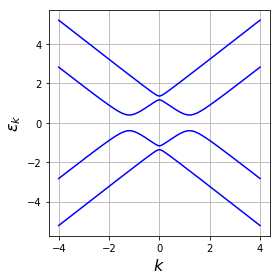

In [2]:
D1=0.4
D2=0.
k0=1.2
G=-0.1

s0=np.array([[1,0],[0,1]])
sx=np.array([[0,1],[1,0]])
sy=np.array([[0,-1j],[1j,0]])
sz=np.array([[1,0],[0,-1]])

k_sw= np.linspace(-1,1,401)*4
Ens= np.zeros((len(k_sw),4))
for i_k in range(len(k_sw)):
    Ham= k_sw[i_k]* np.kron(s0,sz)- k0* np.kron(sz,s0)\
        +D1*np.kron(sy,sy)+ D2*k_sw[i_k]* np.kron(sx,s0)\
        + G* np.kron(sz,sx)
    Ens[i_k,:], _ = np.linalg.eigh(Ham)
    
plt.figure(figsize=(4,4))
plt.plot(k_sw,Ens,'b')
# plt.plot(k_sw,Ens[len(k_sw)-1::-1,:],'r')


plt.xlabel('k')
plt.ylabel('E')
fsize=16
plt.ylabel(r"$\varepsilon_k$",fontsize = fsize)
plt.xlabel(r"$k$",fontsize = fsize)
# plt.ylim(-2,2)
# plt.xlim(-1,4)
# plt.xticks([0,2,4])
# plt.yticks(np.arange(-2,2.1,1))
plt.grid()
plt.tight_layout()
# plt.savefig('figs/nu1_eff_D12_%d_%d.pdf' % (100*D1,100*D2))
plt.show()



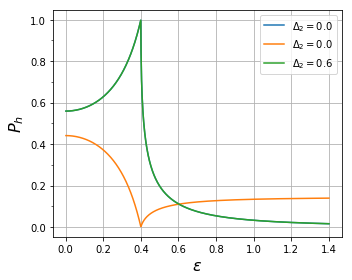

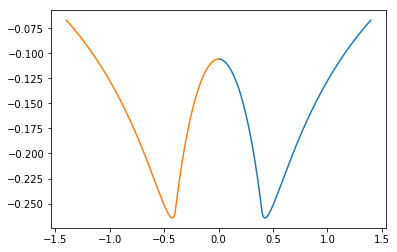

In [38]:
# T matrix with Z
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


Z=.4
Esw0= np.linspace(0.0,1.4,1000)
Esw0=Esw0[1:]
Tz=[[np.cosh(Z),0,-1j*np.sinh(Z),0],\
    [0,np.cosh(Z),0,-1j*np.sinh(Z)],\
    [1j*np.sinh(Z),0,np.cosh(Z),0],\
    [0,1j*np.sinh(Z),0,np.cosh(Z)]]
 
# r=.2
# AB1=(r-np.sqrt(4+ r**2))/2 *np.array([[1,1]]) 
# CD1=-np.array([[1,1]])
# AB2=(r+np.sqrt(4+ r**2))/2 *np.array([[1,-1]])
# CD2=-np.array([[-1,1]])
# AB=np.concatenate((AB1,AB2),axis=0)
# CD=np.concatenate((CD1,CD2),axis=0)
# # Tz=np.kron(sz,np.dot(np.linalg.inv(CD),AB))
# Tz=np.kron(sz,np.dot(np.linalg.inv(AB),CD))

def Reh_calc(D1,D2):
    Ree=np.zeros(len(Esw0))
    Reh=np.zeros(len(Esw0))

    Ham=  -k0* np.kron(sz,s0) +D1*np.kron(sy,sy) #+ G* np.kron(sz,sx)
    vk= np.kron(s0,sz)+ D2*np.kron(sx,s0)
    Hd= np.linalg.inv(vk)

    for i_E in range(len(Esw0)):
        E=Esw0[i_E]
        Ht= np.dot(Hd,E*np.eye(4)-  Ham)
        evs, evecs = np.linalg.eig(Ht)

        i_evan= np.where( np.abs(np.imag(evs)) > 1e-5 )[0]
        ie_T= np.where( np.imag(evs[i_evan]) > 0)[0]
        ie_R= np.where( np.imag(evs[i_evan]) < 0)[0]

        i_prop= np.where( np.abs(np.imag(evs)) < 1e-5 )[0]
        evecs_inv=np.linalg.inv(evecs)
    #     evecs_inv=np.transpose(evecs)
        Jmat = np.reshape(np.diag(np.dot(evecs_inv,np.dot(vk,evecs))),[4,])
        ip_T= np.where( np.real(Jmat[i_prop]) > 0)[0]
        ip_R= np.where( np.real(Jmat[i_prop]) < 0)[0]

        i_T=np.concatenate((i_prop[ip_T],i_evan[ie_T]))
        i_R=np.concatenate((i_prop[ip_R],i_evan[ie_R]))

        evecs= np.dot(evecs,np.diag(1/Jmat**0.5))
        Tevecs = evecs[:,i_T]    
        Revecs = evecs[:,i_R]    
        evecs_0= np.concatenate((Tevecs,Revecs),axis=1)


        Revecs_l= np.array([[0,1,0,0],[0,0,0,1]]).T
        Tevecs_l= np.array([[1,0,0,0],[0,0,1,0]]).T
        evecs_l= np.concatenate((Tevecs_l,Revecs_l),axis=1)

        Tmat=sp.linalg.solve(evecs_0,evecs_l)
#         Tz=[[1-1j*Z,0,-1j*Z,0],\
#             [0,1+1j*Z,0,-1j*Z],\
#             [1j*Z,0,1+1j*Z,0],\
#             [0,1j*Z,0,1-1j*Z]]
        Tt=np.dot(Tmat,Tz)
        TLL=Tt[np.ix_([2,3],[2,3])]
        TLR=Tt[np.ix_([2,3],[0,1])]
    #     TRL=Tt[np.ix_([0,1],[2,3])]
        x= -sp.linalg.solve(TLL,TLR)
    #     x= -np.dot(np.linalg.inv(TLL),TLR)
        Ree[i_E] = np.abs(x[0,0])**2
        Reh[i_E] = np.abs(x[1,0])**2
    #     print(Ree[i_E],Reh[i_E])

    return Ree,Reh

fig, ax = plt.subplots(figsize=(5,4))

D21=0.
Ree1,Reh1= Reh_calc(D1=D1,D2=D21)
plt.plot(Esw0,Reh1,label='$\Delta_2=%.1f$' % (D21))
plt.plot(Esw0,Ree1,label='$\Delta_2=%.1f$' % (D21))

D22=0.6
Ree2,Reh2= Reh_calc(D1=D1,D2=D22)
plt.plot(Esw0,Reh2,label='$\Delta_2=%.1f$' % (D22))
# plt.plot(Esw0,Ree0[:,0]+Ree0[:,1])
# plt.plot(Esw/D2,Reh[:,0]+Reh[:,1]-(Ree[:,0]+Ree[:,1]))
# plt.plot(Esw/Delta,np.imag(Reh))
# plt.plot(Esw/Delta,np.imag(Ree))
plt.grid()
# plt.ylim(0,1.1)

ax.legend()
fsize=16
plt.ylabel(r"$P_h$",fontsize = fsize)
plt.xlabel(r"$\varepsilon$",fontsize = fsize)
# plt.xticks(np.arange(-0.08,0.081,0.04))
# plt.yticks(np.arange(0,1.1,0.5))
# plt.legend(loc='upper right')

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

plt.tight_layout()
# plt.savefig('figs/CAR_eff_nu1_vs_E.pdf')
plt.show()

y=1-Ree1+Reh1 
I=integrate.cumtrapz(y,Esw0)
# I=np.zeros(len(Esw0))
# for i_1 in range(len(Esw0)):
#     I[i_1]=np.trapz(y[:i_1],Esw0[:i_1])

dE=Esw0[1]-Esw0[0]
plt.figure()
# plt.plot(Esw0[0:len(Esw0)-1],I[1:len(Esw0)]/Esw0[0:len(Esw0)-1])
# plt.plot(Esw0[0:len(Esw0)-1],I[0:len(Esw0)-1]/(Esw0[1:len(Esw0)]-Esw0[0]),'-')
xplot=Esw0[0:len(Esw0)-1]
yplot=(Esw0[1:len(Esw0)]-Esw0[0])/I[0:len(Esw0)-1]-1
plt.plot(xplot,yplot,'-')
plt.plot(-xplot,yplot,'-')
plt.show()

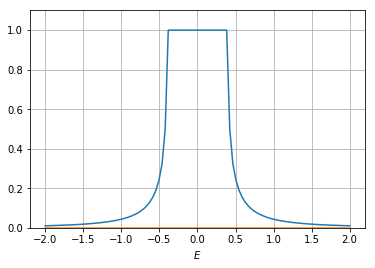

In [66]:
# usual boundary matching

Esw= np.linspace(-1,1,100)*2
# Esw=[0]

Ree=np.zeros(len(Esw))
Reh=np.zeros(len(Esw))

Ham=  -k0* np.kron(sz,s0) +D1*np.kron(sy,sy) #+ G* np.kron(sz,sx)
vk= np.kron(s0,sz)+ D2*np.kron(sx,s0)
Hd= np.linalg.inv(vk)

for i_E in range(len(Esw)):
    E=Esw[i_E]
    Ht= np.dot(Hd,E*np.eye(4)-  Ham)
    evs, evecs = np.linalg.eig(Ht)

    i_evan= np.where( np.abs(np.imag(evs)) > 1e-5 )[0]
    ie_T= np.where( np.imag(evs[i_evan]) > 0)[0]

    i_prop= np.where( np.abs(np.imag(evs)) < 1e-5 )[0]
#     ip_T= np.where( np.real(evs[i_prop]) > 0)[0]
    Jmat = np.reshape(np.diag(np.dot(np.transpose(evecs),np.dot(vk,evecs))),[4,])
    ip_T= np.where( np.real(Jmat[i_prop]) > 0)[0]

    i_p=np.concatenate((i_prop[ip_T],i_evan[ie_T]))
    
    evecs= np.dot(evecs,np.diag(1/Jmat**0.5))
    Tevecs = evecs[:,i_p]    
    
    Revecs_l= np.array([[0,1,0,0],[0,0,0,1]]).T
    Tevecs_l= np.array([1,0,0,0]).T

    Psi_t=np.concatenate((Tevecs,-Revecs_l),axis=1)
    Psi_inc= Tevecs_l
    x=sp.linalg.solve(Psi_t,Psi_inc)
    Ree[i_E] = np.abs(x[2])**2
    Reh[i_E] = np.abs(x[3])**2
#     print(Ree[i_E],Reh[i_E])
        
plt.figure()
plt.plot(Esw,Reh)
plt.plot(Esw,Ree)
# plt.plot(Esw/Delta,np.imag(Reh))
# plt.plot(Esw/Delta,np.imag(Ree))
plt.grid()
plt.ylim(0,1.1)

plt.xlabel(r'$r_{eh}$')
plt.xlabel(r'$E$')
plt.show()

In [16]:
print(Tevecs)

[[ 7.09777927e-01-3.19615029e-16j -3.55780650e-02+2.53331541e-17j]
 [-8.56767151e-18-3.55780650e-02j  2.10420918e-16-7.09777927e-01j]
 [-3.55780650e-02+8.33439181e-18j  7.09777927e-01-2.10277362e-16j]
 [-3.18767802e-16+7.09777927e-01j -2.81970917e-17+3.55780650e-02j]]


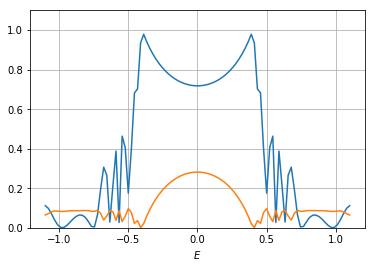

In [138]:
# T matrix with random disorder

Nrep=1
Nimp=0
Uimp=.2
L=100/D1
Zimp=0.1
Z=0.3
Esw= np.linspace(-1.1,1.1,100)

Ree=np.zeros(len(Esw))
Reh=np.zeros(len(Esw))

Ham=  -k0* np.kron(sz,s0) +D1*np.kron(sy,sy)+ G* np.kron(sz,sx)
vk= np.kron(s0,sz)+ D2*np.kron(sx,s0)
Hd= np.linalg.inv(vk)


for i_E in range(len(Esw)):
    E=Esw[i_E]
    Hd= np.linalg.inv(np.kron(s0,sz)+ D2*np.kron(sx,s0))
    Ht= np.dot(Hd,E*np.eye(4)-  Ham)
    evs, evecs = np.linalg.eig(Ht)

    i_evan= np.where( np.abs(np.imag(evs)) > 1e-5 )[0]
    ie_T= np.where( np.imag(evs[i_evan]) > 0)[0]
    ie_R= np.where( np.imag(evs[i_evan]) < 0)[0]

    i_prop= np.where( np.abs(np.imag(evs)) < 1e-5 )[0]
    evecs_inv=np.linalg.inv(evecs)
    #     evecs_inv=np.transpose(evecs)
    Jmat = np.reshape(np.diag(np.dot(evecs_inv,np.dot(vk,evecs))),[4,])
    ip_T= np.where( np.real(Jmat[i_prop]) > 0)[0]
    ip_R= np.where( np.real(Jmat[i_prop]) < 0)[0]

    i_T=np.concatenate((i_prop[ip_T],i_evan[ie_T]))
    i_R=np.concatenate((i_prop[ip_R],i_evan[ie_R]))

    evecs= np.dot(evecs,np.diag(1/Jmat**0.5))
    Tevecs = evecs[:,i_T]    
    Revecs = evecs[:,i_R]    
    evecs_0= np.concatenate((Tevecs,Revecs),axis=1)
    evs=evs[np.concatenate((i_T,i_R))]
    
    Revecs_l= np.array([[0,1,0,0],[0,0,0,1]]).T
    Tevecs_l= np.array([[1,0,0,0],[0,0,1,0]]).T
    evecs_l= np.concatenate((Tevecs_l,Revecs_l),axis=1)
    
    Tl=sp.linalg.solve(evecs_0,evecs_l)
    Tr=sp.linalg.solve(evecs_l,evecs_0)
    Tz=[[1-1j*Z,0,-1j*Z,0],\
        [0,1+1j*Z,0,-1j*Z],\
        [1j*Z,0,1+1j*Z,0],\
        [0,1j*Z,0,1-1j*Z]]
#     Ts=[[1-1j*Zimp,0,-1j*Zimp,0],\
#         [0,1+1j*Zimp,0,-1j*Zimp],\
#         [1j*Zimp,0,1+1j*Zimp,0],\
#         [0,1j*Zimp,0,1-1j*Zimp]]
#     Ts=np.linalg.inv(Ts)
    Ts=sp.linalg.expm(1j*Uimp*np.dot(Hd,np.kron(sz,sx)))
#     Ts=sp.linalg.expm(1j*Uimp*np.dot(Hd,np.kron(sz,sz)))

    def Asc(x):
        return np.diag(np.exp(1j*evs*x))
        
    for i_r in range(Nrep):
        x_imp=np.sort(np.random.rand(Nimp)*L)
        x_imp=np.concatenate(([0],x_imp))
        
        Tmat=np.dot(Tl,Tz)
#         Tmat=Tl #np.eye(4)
        for i_n in range(1,Nimp+1):
            Tmat=np.dot(Ts,np.dot(Asc(x_imp[i_n]-x_imp[i_n-1]),Tmat))
        Tmat=np.dot(Asc(L-x_imp[Nimp]),Tmat)
        Tt=np.dot(Tr,Tmat)
        TLL=Tt[np.ix_([2,3],[2,3])]
        TLR=Tt[np.ix_([2,3],[0,1])]
        x= -sp.linalg.solve(TLL,TLR)
        Ree[i_E] = np.abs(x[0,0])**2
        Reh[i_E] = np.abs(x[1,0])**2

plt.figure()
plt.plot(Esw,Reh)
plt.plot(Esw,Ree)
# plt.plot(Esw/Delta,np.imag(Reh))
# plt.plot(Esw/Delta,np.imag(Ree))
plt.grid()
plt.ylim(0,1.1)

plt.xlabel(r'$r_{eh}$')
plt.xlabel(r'$E$')
plt.show()

In [77]:
# T matrix with random disorder

Nrep=1000
Nimp=30
Uimp=1.0
L=10/D1
# Zimp=0.2
Z=0.
Esw= np.linspace(-1.1,1.1,30)

Ree=np.zeros((len(Esw),Nrep))
Reh=np.zeros((len(Esw),Nrep))

Ham=  -k0* np.kron(sz,s0) +D1*np.kron(sy,sy) #+ G* np.kron(sz,sx)
vk= np.kron(s0,sz)+ D2*np.kron(sx,s0)
Hd= np.linalg.inv(vk)


for i_E in range(len(Esw)):
    E=Esw[i_E]
    print(i_E,end='\r')
    Ht= np.dot(Hd,E*np.eye(4)-  Ham)
    evs, evecs = np.linalg.eig(Ht)

    evecs_inv=np.linalg.inv(evecs)
    #     evecs_inv=np.transpose(evecs)
    Jmat = np.reshape(np.diag(np.dot(evecs_inv,np.dot(vk,evecs))),[4,])
    evecs_0= np.dot(evecs,np.diag(1/Jmat**0.5))

    
    Revecs_l= np.array([[0,1,0,0],[0,0,0,1]]).T
    Tevecs_l= np.array([[1,0,0,0],[0,0,1,0]]).T
    evecs_l= np.concatenate((Tevecs_l,Revecs_l),axis=1)
    
    Tl=evecs_l
    Tr=np.linalg.inv(evecs_l)
#     Tl=sp.linalg.solve(evecs_0,evecs_l)
#     Tr=sp.linalg.solve(evecs_l,evecs_0)
    Tz=[[1-1j*Z,0,-1j*Z,0],\
        [0,1+1j*Z,0,-1j*Z],\
        [1j*Z,0,1+1j*Z,0],\
        [0,1j*Z,0,1-1j*Z]]
#     Ts=[[1-1j*Zimp,0,-1j*Zimp,0],\
#         [0,1+1j*Zimp,0,-1j*Zimp],\
#         [1j*Zimp,0,1+1j*Zimp,0],\
#         [0,1j*Zimp,0,1-1j*Zimp]]
#     Ts=np.linalg.inv(Ts)
#     Ts=sp.linalg.expm(1j*Uimp*np.dot(Hd,np.kron(sz,sz)))

    def Asc(x):
        return np.dot(evecs,np.dot(np.diag(np.exp(1j*evs*x)),evecs_inv))
        
    for i_r in range(Nrep):

        x_imp=np.sort(np.random.rand(Nimp)*L)
        x_imp=np.concatenate(([0],x_imp))
        
#         Tmat=np.dot(Tl,Tz)
        Tmat=np.dot(Tl,Tz) #np.eye(4)
        for i_n in range(1,Nimp+1):
            Ur=np.random.rand()-0.5
            Ts=sp.linalg.expm(1j*Uimp*Ur*np.dot(Hd,np.kron(sz,sx)))
            Tmat=np.dot(Ts,np.dot(Asc(x_imp[i_n]-x_imp[i_n-1]),Tmat))
        Tmat=np.dot(Asc(L-x_imp[Nimp]),Tmat)
        Tt=np.dot(Tr,Tmat)
        TLL=Tt[np.ix_([2,3],[2,3])]
        TLR=Tt[np.ix_([2,3],[0,1])]
        x= -sp.linalg.solve(TLL,TLR)
        Ree[i_E,i_r] = np.abs(x[0,0])**2
        Reh[i_E,i_r] = np.abs(x[1,0])**2

print('Done!')

Done!


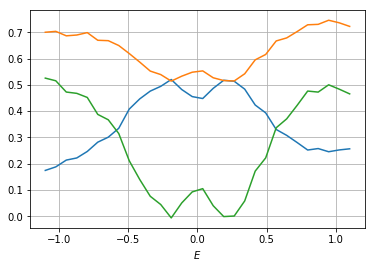

In [78]:
plt.figure()
# plt.plot(Esw,Reh)
# plt.plot(Esw,Ree)
plt.plot(Esw,np.mean(Reh,1))
plt.plot(Esw,np.mean(Ree,1))
plt.plot(Esw,-np.mean(Reh,1)+np.mean(Ree,1))
plt.grid()
# plt.ylim(0,1.1)

plt.xlabel(r'$r_{eh}$')
plt.xlabel(r'$E$')
plt.show()

In [75]:
# T matrix with random disorder

Nrep=100
Nimp=80
L=40/D1
dl=L/Nimp
# Zimp=0.2
Z=0.
Esw= np.linspace(-4.1,4.1,30)

Ree=np.zeros((len(Esw),Nrep))
Reh=np.zeros((len(Esw),Nrep))

vk= np.kron(s0,sz)+ D2*np.kron(sx,s0)
Hd= np.linalg.inv(vk)

D1s=D1*(np.random.rand(Nimp,Nrep)-0.5)
# D1s=D1*(np.random.rand(Nimp,Nrep)-0.5)*np.exp(1j*np.random.rand(Nimp,Nrep)*2*pi)
# D1s=D1*np.random.randn(Nimp,Nrep)
# D1s=D1*np.ones((Nimp,Nrep))

Revecs_l= np.array([[0,1,0,0],[0,0,0,1]]).T
Tevecs_l= np.array([[1,0,0,0],[0,0,1,0]]).T
evecs_l= np.concatenate((Tevecs_l,Revecs_l),axis=1)

Tl=evecs_l
Tr=np.linalg.inv(evecs_l)
Tz=[[1-1j*Z,0,-1j*Z,0],\
    [0,1+1j*Z,0,-1j*Z],\
    [1j*Z,0,1+1j*Z,0],\
    [0,1j*Z,0,1-1j*Z]]

for i_r in range(Nrep):
    print(i_r,end='\r')
    
    for i_E in range(len(Esw)):
        E=Esw[i_E]
        
        Tmat=np.dot(Tl,Tz)
        for i_n in range(Nimp):
#             Ham=  -k0* np.kron(sz,s0) +D1s[i_n,i_r]*np.kron(sy,sy)
            Ham=  -k0* np.kron(sz,s0) +np.real(D1s[i_n,i_r])*np.kron(sy,sy)\
                +np.imag(D1s[i_n,i_r])*np.kron(sx,sy)
            Tmat=np.dot(sp.linalg.expm(1j*np.dot(Hd,E*np.eye(4)-  Ham)*dl),Tmat)
            
        Tt=np.dot(Tr,Tmat)
        TLL=Tt[np.ix_([2,3],[2,3])]
        TLR=Tt[np.ix_([2,3],[0,1])]
        x= -sp.linalg.solve(TLL,TLR)
        Ree[i_E,i_r] = np.abs(x[0,0])**2
        Reh[i_E,i_r] = np.abs(x[1,0])**2

print('Done!')

Done!


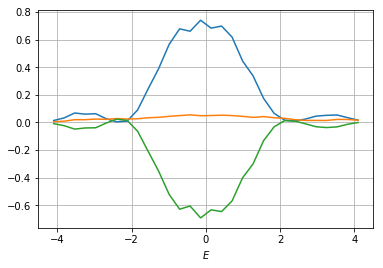

In [76]:
plt.figure()
# plt.plot(Esw,Reh)
# plt.plot(Esw,Ree)
plt.plot(Esw,np.mean(Reh,1))
plt.plot(Esw,np.mean(Ree,1))
plt.plot(Esw,-np.mean(Reh,1)+np.mean(Ree,1))

x=np.mean(Ree,1)-np.mean(Reh,1)
# plt.plot(Esw,x/(1-x))

plt.grid()
# plt.ylim(-1,1.1)

plt.xlabel(r'$r_{eh}$')
plt.xlabel(r'$E$')
plt.show()

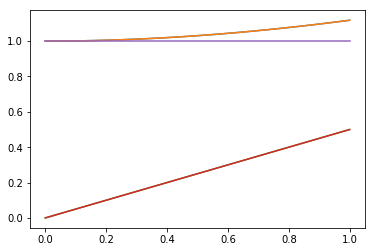

In [30]:
r_sw = np.linspace(0,1)

T= np.zeros((2,2,len(r_sw)))

for i_r in range(len(r_sw)):
    r= r_sw[i_r]
    AB1=(r-np.sqrt(4+ r**2))/2 *np.array([[1,1]]) 
    CD1=-np.array([[1,1]])
    AB2=(r+np.sqrt(4+ r**2))/2 *np.array([[1,-1]])
    CD2=-np.array([[-1,1]])
    AB=np.concatenate((AB1,AB2),axis=0)
    CD=np.concatenate((CD1,CD2),axis=0)
#     T[:,:,i_r]=np.dot(np.linalg.inv(CD),AB)
    T[:,:,i_r]=np.dot(np.linalg.inv(AB),CD)

    
plt.figure()
plt.plot(r_sw,T[0,0,:])
plt.plot(r_sw,T[1,1,:])
plt.plot(r_sw,T[0,1,:])
plt.plot(r_sw,T[1,0,:])
det=T[0,0,:]*T[1,1,:]-T[1,0,:]*T[0,1,:]
plt.plot(r_sw,det)
plt.show()


In [9]:
print(AB1.shape)

(1, 2)
